0
Episode 0 
 Avg -500.0
500
Episode 500 
 Avg -500.0
1000
Episode 1000 
 Avg -500.0
1500
Episode 1500 
 Avg -500.0
2000
Episode 2000 
 Avg -500.0


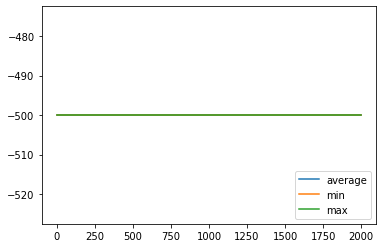

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# imports mountain car environment
gym.envs.register(
    id='MountainCarMyEasyVersion-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=500,      # MountainCar-v0 uses 200
)
env = gym.make('MountainCarMyEasyVersion-v0')





env.reset()

LEARNING_RATE = 0.1
DISCOUNT = 0.9    #try to keep between 0.9 and 0.99
EPISODES = 2_500


SHOW_EVERY = 500

#working with discrete ranges instead of continuous for reduced computational complexity
#seperating the range of observations into n chunks 
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/ DISCRETE_OS_SIZE

# between 0,1 the highier the episilon, the more random (exploratory)
epsilon = 1
START_EPISILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2

epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPISILON_DECAYING)



# we want to look up for any position/velocity, what is the best action?
# we have to build a q-table (action on one axis, state on the other)
# i.e. the largest Q-value 

# intialize table of random q-values of every state by every action
np.random.seed(10)
q_table = np.random.uniform(low=-2, high=0, size = (DISCRETE_OS_SIZE + [env.action_space.n]))


ep_rewards = []
aggr_ep_rewards = {'ep':[], 'avg': [], 'min': [], 'max' : []}

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/(discrete_os_win_size)
    return tuple(discrete_state.astype(np.int))


for episode in range(EPISODES):
    episode_reward = 0

    
    if episode % SHOW_EVERY == 0:
        print(episode)
        render = True
    else:
        render = False
        
    discrete_state = get_discrete_state(env.reset())

    done = False

    while not done:
        action = np.argmax(q_table[discrete_state])
        new_state, reward, done, _ = env.step(action)
        
        episode_reward += reward

        new_discrete_state = get_discrete_state(new_state)
        
#         if render:
#             env.render()

        if not done:
            max_future_q = np.max(q_table[discrete_state])   #will be multuplied to discount
            current_q = q_table[discrete_state + (action, )]

            # calculating q-values
            new_q = (1-LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q #updating discrete state in the qtable

        elif new_state[0] >= env.goal_position:
            print("we made it on {}".format(episode))
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state
        
    if END_EPSILON_DECAYING >= episode >= START_EPISILON_DECAYING:
        epsilon -= epsilon_decay_value
        
    ep_rewards.append(episode_reward)
    
    if not episode % SHOW_EVERY:
        average_reward = sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))
        
        print("Episode {0} \n Avg {1}".format(episode, average_reward))


env.close()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'average')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc=4)
plt.show()